# Queuing Models

Built upon PROBABILITY, MARKOV CHAINS, QUEUES, AND SIMULATION, William R. Steward, P. 682

### Import librairies

In [589]:
import matplotlib.pyplot as plt
from IPython import display # Dynamic plot
from math import *
import numpy as np
import random
import seaborn as sns
import pandas as pd
import time

### Define simulation functions

In [977]:
def Random_sample(param, model):
    if model == 'D':
        return param
    else:
        return random.expovariate(param)

In [ ]:
## WIP ##
def Pannes(batch_size, probability):
    random_sample = random.random()
    return

In [1379]:
def Simulation(parameters, N):
    #Initialization
    start_time = time.time()
    col_C = ['priority', 'status', 'arrival time', 'service time', 'departure time']
    Customers = pd.DataFrame(columns = col_C)
    col_Q = ['time', 'waiting P0', 'waiting P1', 'servicing',' P0 serviced',' P1 serviced','lost','servers live']
    Queue = pd.DataFrame(columns = col_Q)
    n, n_service, n_serviced, n_lost, n_P0_serviced, n_P0_waiting = 0, 0, 0, 0, 0, 0
    P0_batch = 0
    P0_index, P1_index = [], []
    servers_in_use = 0
    t, t_latest_departure = 0, np.inf
    t_next_arrival = Random_sample(parameters['lmbda'], parameters['arrival model'])
    #departing_index = -1
    
    if parameters['priority'] == True:
        t_next_priority = Random_sample(parameters['priority lmbda'], parameters['priority model'])
        next_priority = 'P0' if t_next_priority < t_next_arrival else 'P1'
    else: 
        t_next_priority = np.inf
        next_priority = 'P1'
    t_latest_arrival = min(t_next_arrival, t_next_priority) 
    Queue.loc[Queue.shape[0]] = [t, n_P0_waiting , n - n_service - n_P0_waiting, n_service, n_P0_serviced, n_serviced - n_P0_serviced, n_lost, parameters["c"]]
    
    while Customers[Customers['status']=='Serviced'].shape[0] < N:

        if t_latest_arrival < t_latest_departure: #Arrival event
            t = t_latest_arrival
            n_serviced = Customers[Customers['status']=='Serviced'].shape[0]
            
            if n < N-n_serviced: #Queue still open
                Customers.loc[Customers.shape[0]] = [next_priority, 'Waiting', t, -1.0, -1.0]
                if n - n_service < parameters["K"]: #Queue not full
                    n += 1
                    
                    if servers_in_use < parameters["c"]: #Server available
                        servers_in_use += 1 
                        b = parameters['units'] * parameters["unit_size"] #Define batch size + pannes coming soon
                        batch = min(b,Customers[Customers['status']=='Waiting'].shape[0])
                        #batch = 1
                        n_service += batch
                        print(t)
                        t_depart = t + Random_sample(parameters['mu'], parameters['service model'])
                        
                        Customers.loc[Customers.shape[0]-batch:,'status'] = ['In service']
                        Customers.loc[Customers.shape[0]-batch:,['service time', 'departure time']] =[float(t), float(t_depart)]

                        t_latest_departure  = min(Customers[Customers['departure time'] > t]['departure time'])
                        #departing_index = Customers[Customers['departure time'] > t]['departure time'].idxmin()
                else: #Queue open but full: customer lost
                    n_lost += 1
                    Customers.loc[Customers.shape[0]-1, 'status'] = ['Lost']
            
            if next_priority == 'P1':
                t_next_arrival = t + Random_sample(parameters['lmbda'], parameters['arrival model'])
            if next_priority == 'P0':
                t_next_priority = t + Random_sample(parameters['priority lmbda'], parameters['priority model'])
            next_priority = 'P0' if t_next_priority < t_next_arrival else 'P1'
            t_latest_arrival = min(t_next_arrival, t_next_priority)
            #print(t_next_arrival, t_next_priority, next_priority, t_latest_arrival)
                
        else: #Departure event
            batch = Customers.loc[(Customers['departure time'] == t_latest_departure) & (Customers['status'] == 'In service')].shape[0] #Get completed batch data
            t = t_latest_departure
            n -= batch
            n_service -= batch
            servers_in_use -= 1
            Customers.loc[(Customers['departure time'] == t_latest_departure) & (Customers['status'] == 'In service'),'status'] = ['Serviced']
            n_serviced = Customers[Customers['status'] == 'Serviced'].shape[0]
            
            if servers_in_use < parameters["c"] and n-n_service > 0: # Free server serves next customer waiting
                b = parameters['units'] * parameters["unit_size"]
                batch = min(b, Customers[Customers['status'] == 'Waiting'].shape[0])
                servers_in_use += 1
                n_service += batch
                t_depart = t + Random_sample(parameters['mu'], parameters['service model'])
                
                if Customers.loc[(Customers['priority'] == 'P0') & (Customers['status']=='Waiting')].shape[0] > 0:
                    P_0 = Customers[Customers['priority'] == 'P0']
                    #next_in_line = P[Customers['status'] == 'Waiting']['arrival time'].idxmin()
                    P0_batch = min(b, P_0[P_0['status'] == 'Waiting'].shape[0])
                    P0_index = P_0.index[P_0['status'] == 'Waiting'].tolist()
                    Customers.loc[P0_index[:P0_batch], ['status', 'service time', 'departure time']] = ['In service', t, t_depart]
                    if batch - P0_batch > 0: # Room for P1 customers
                        P_1 = Customers[Customers['status'] == 'Waiting']
                        P1_index = P_1.index[P_1['priority'] == 'P1'].tolist()
                        Customers.loc[P1_index[:(batch - P0_batch)],['status', 'service time', 'departure time']] = ['In service', t, t_depart]
                    
                else:
                    next_in_line = Customers[Customers['status'] == 'Waiting']['arrival time'].idxmin()
                    Customers.loc[next_in_line:next_in_line + batch - 1,['status', 'service time', 'departure time']] = ['In service', t, t_depart]
            
            try: #Generate next departure time
                t_latest_departure  = min(Customers[Customers['departure time'] > t]['departure time'])
                #departing_index = Customers[Customers['departure time'] > t]['departure time'].idxmin()
            except (ValueError, TypeError):
                t_latest_departure = np.inf
        
        n_P0_waiting = Customers.loc[(Customers['priority'] == 'P0') & (Customers['status'] == 'Waiting')].shape[0]
        n_P0_serviced = Customers.loc[(Customers['status'] == 'Serviced') & (Customers['priority'] == 'P0')].shape[0]
        Queue.loc[Queue.shape[0]] = [t, n_P0_waiting , n - n_service - n_P0_waiting, n_service, n_P0_serviced, n_serviced - n_P0_serviced, n_lost, parameters["c"]]
        #print(Customers)
    sim_time = time.time() - start_time #Time to compute
    return Customers, Queue, sim_time
                    

In [1380]:
def performance(C, Q, sim_time):
    S = C[C.loc[:,'status']=='Serviced'].copy()
    S.loc[:,'waited'] = S.loc[:,'service time'] - S.loc[:,'arrival time']
    S.loc[:,'serviced'] = S.loc[:,'departure time'] - S.loc[:,'service time']
    Q2 = Q.copy()
    Q2.loc[:,'time diff'] = Q2.loc[:, 'time'] - Q2.loc[:, 'time'].shift(1)
    Q2 = Q2.iloc[1:]
    Q2.loc[:,'weighted wait'] = Q2.loc[:,'time diff'] * Q2.loc[:, 'waiting P1']
    Q3 = Q2[Q2.loc[:,'waiting P1'] > 0].copy()
    
    interarrival = round((C['arrival time'].iloc[-1] - C['arrival time'].iloc[0])/C.shape[0], 2)
    avg_wait = round(S['waited'].sum()/N, 2)
    avg_service = round(S['serviced'].sum()/N, 2)
    mean_length = round(Q2['weighted wait'].sum()/max(Q['time']), 2)
    mean_length_nn = round(Q3['weighted wait'].sum()/Q3['time diff'].sum(), 2)
    Q2.loc[:,'Var'] = (Q2.loc[:,'weighted wait'] - mean_length)**2
    queue_variance = round(sqrt(Q2['Var'].sum()/(Q2.shape[0]-1)), 2)
    lost = max(Q['lost'])
 
    print("Mean interarrival time: {}".format(interarrival))
    print("Mean queueing time (excl. service): {}".format(avg_wait))
    print("Mean service time: {}".format(avg_service))
    print("Mean queue length: {}".format(mean_length))
    print("Mean queue length (non-zero): {}".format(mean_length_nn))
    print("Queue stdev: {}".format(queue_variance))
    print("Customers lost: {}".format(int(lost)))
    print(" ")
    print("Simulation duration: {} seconds".format(round(sim_time, 2)))

### Simulations

parameters = {
    
    "lmbda": interrarrival time parameter 1/mean
    , "mu": service time parameter 1/mean
    , "c": number of servers
    , "K": max queue capacity (if infinite type np.inf)
    , "units": number of units
    , "unit_size": unit capacity
    , "arrival model": "M" for exponential, "D" for constant 
    , "service model": "M" for exponential, "D" for constant 
    , "priority": WIP 
    , "priority lmbda": WIP
    , "priority model": WIP
}

N: number of customers to serve

In [1395]:
parameters = {                    
    "lmbda": 1                  #1/mean interarrival time
    , "mu": 1                 #1/mean service time or constant
    , "c": 1                            #number of servers
    , "K": 100                       #max waiting length
    , "units": 1                           #batch per server
    , "unit_size": 1                           #batch per server
    , "arrival model": 'M'  
    , "service model": 'D'
    
    , "priority": True          
    , "priority lmbda": 0.2       # 1 out of lmbda is a priority customer on average
    , "priority model": 'M'
}

N = 2000

In [1396]:
C, Q, sim_time = Simulation(parameters, N)
performance(C, Q, sim_time)

0.517110294405263
Mean interarrival time: 0.83
Mean queueing time (excl. service): 84.29
Mean service time: 1.0
Mean queue length: 83.94
Mean queue length (non-zero): 84.05
Queue stdev: 55.3
Customers lost: 291
 
Simulation duration: 31.58 seconds


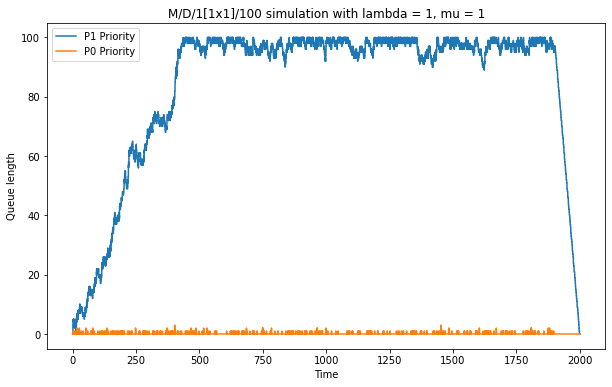

In [1398]:
fig, ax =plt.subplots(figsize=(10, 6))
plt.step('time','waiting P1',data=Q)
plt.step('time','waiting P0',data=Q)
plt.title(f"{parameters['arrival model']}/{parameters['service model']}/{parameters['c']}[{parameters['unit_size']}x{parameters['units']}]/{parameters['K']} simulation with lambda = {parameters['lmbda']}, mu = {parameters['mu']}")
plt.xlabel("Time")
plt.ylabel("Queue length")
plt.legend(["P1 Priority", "P0 Priority"])
plt.show()